# MIC - MIC Test Strip

Plot data from experiment BN4 - bacteria streaked onto 15cm agar plates (containing 50ug/mL zeocin) that contained MIC strips for detecting resistance to different beta lactam antibiotics.


In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
GROWTH_CURVES_DIR = LOCAL_DIR+'/figures/growth_curves'
OUTPUT_DIR = GROWTH_CURVES_DIR+'/mic_strips'
if not os.path.exists(GROWTH_CURVES_DIR): os.makedirs(GROWTH_CURVES_DIR)
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

RAW_DATA_SHEETNAME = 'growth_micstrips'

MAX_TESTED = 256
OVER_MAX = 1.5 * MAX_TESTED

ANTIBIOTICS = {
    'Ampicillin': {'val_offset': 0.8},
    'Aztreonam': {'val_offset': 0.013},
    'Ceftazidime': {'val_offset': 0.028},
    'Cefoxitin': {'val_offset': 0.7},
    'Cephalothin': {'val_offset': 1.5},
}

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
def load_data():  
    toreturn = pd.read_excel(FHS.get_data_filename(), 
                             sheet_name=RAW_DATA_SHEETNAME).melt(
        id_vars=['sample_id', 'antibiotic'], 
        value_vars=['rep_1', 'rep_2', 'rep_3'],
    ).rename(
        {'variable': 'replicate'}, 
        axis='columns'
    )

    #drop the rep_ string and set as int
    toreturn.replicate = toreturn.replicate.apply(
        lambda rep: int(rep[-1])
    ).reset_index(
        drop=True
    )

    #replace 'max' in the dataframe with an actual value
    toreturn.value = toreturn.value.apply(
        lambda val: OVER_MAX if val == 'max' else val
    )

    #add the official manuscript name to the dataframe
    toreturn = FHS.add_manuscript_name_to_df(
        toreturn, 
        synonym_column = 'sample_id', 
        new_column = 'manuscript_name'
    )

    def aggregate_replicates(manuscript_name, antibiotic):
        '''
        Determine single replicate value for a particular sample. This is the
        mean value for all antibiotics except for Cephalothin (see below). Note
        that technically this isn't the mean for those samples that were higher
        than the max value tested (256 ug/mL), but only Cephalothin had any noise
        with these values (i.e., for ampicillin that were over max were 
        consistant across all replicates)

        Cephalothin had some replicates had a higher MIC than the max tested value,
        some of which were not consistant across all replicates. As these samples 
        cannot be averaged, we take a different approach for determining an
        aggregate value of all replicates of cephalothin: 
         (1) if there is a mode, use the mode
         (2) select the median
         STATS for these samples:
           - 4 are in perfect agreement for all replicates (WT, rw-consensus, 95.b, 80.a)
           - 8 have a mode (98.a, 95.a, 90.b, 80.b, 70.a, 70.b, 50.a, 50.b)
           - 5 used median (neg. ctrl, 98.b, 90.a, opt.a, opt.b)
        '''
        vals = list(toreturn[(
            (toreturn.antibiotic == antibiotic) &
            (toreturn.manuscript_name == manuscript_name)
        )].value)
        if len(vals) != 3: raise Exception(
            '{0} replicates found - expected 3'.format(len(vals))
        )

        if antibiotic == 'Cephalothin':
            #is there a mode? if so, return it
            if vals[0] == vals[1] or vals[0] == vals[2]: return vals[0]
            if vals[1] == vals[2]: return vals[1]

            #no mode, return the median
            return np.median(vals)
        return np.mean(vals)
        
    toreturn['agg_value'] = toreturn.apply(
        lambda row: aggregate_replicates(row.manuscript_name, row.antibiotic),
        axis='columns'
    )
    return toreturn

In [5]:
#load all data
df = load_data()
sample_order = FHS.get_sample_order(df.manuscript_name)

df['order'] = df['sample_id'].apply(
    lambda s: sample_order.index(s)
)

df = df.sort_values(
    by=['antibiotic', 'order', 'replicate']
).reset_index(drop=True)

## Plot Data

In [6]:
def plot(antibiotic, save_fig=False, hide_labels=False):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(8, 3)

    df_antibiotic = df[df.antibiotic==antibiotic]

    #barplot of aggregated value (mean for all but Cephalothin)
    label = 'mean' if antibiotic != 'Cephalothin' else 'mode or median'
    label += ' of replicates'

    bottom = 0.5*ANTIBIOTICS[antibiotic]['val_offset']
    bp_df = df_antibiotic[['manuscript_name','agg_value']].drop_duplicates()
    bp = ax.bar(
        bp_df['manuscript_name'],
        bp_df['agg_value'] - bottom,
        color='lightgray',
        bottom=bottom
    )

    #plot raw datapoints, but "smart" jitter so all are visible
    rawdatapoints = {'x':[], 'y': []}
    for idx, samplename in enumerate(sample_order):
        bar_details = bp.patches[idx]
        padding = 0.2 * bar_details.get_width()
        bar_x_start = bar_details.xy[0] + padding
        bar_width = bar_details.get_width() - (2 * padding)

        rep_spacing = 1 / 2 * bar_width

        tmp_df = df_antibiotic[df_antibiotic.manuscript_name==samplename]
        for i in range(0, 3):
            rawdatapoints['x'].append(bar_x_start + (i * rep_spacing))
            tmp_df = df_antibiotic[(
                (df_antibiotic.manuscript_name==samplename) &
                (df_antibiotic.replicate==i+1)
            )]
            rawdatapoints['y'].append(tmp_df.value)
    
    ax.scatter(
        x=rawdatapoints['x'], y=rawdatapoints['y'], 
        color='darkred', s=10, zorder=10,
        marker='D', linewidth=0
    )

    #add text values to result
    for idx, samplename in enumerate(sample_order):
        bar_details = bp.patches[idx]
        val = df_antibiotic[df_antibiotic.manuscript_name==samplename].iloc[0].agg_value
        valstr = round(val, 3)
        if val == OVER_MAX:
            valstr = '> 256'

        ax.text(
            x=bar_details.xy[0] + (bar_details.get_width() / 2), 
            y=ANTIBIOTICS[antibiotic]['val_offset']/1.75,
            horizontalalignment='center', verticalalignment='bottom',
            s='{0}'.format(valstr),
            fontsize=8
        )

    #cutoff line 
    cutoff_color='red'
    if np.max(df_antibiotic.value) == OVER_MAX:
        ax.axhline(y = MAX_TESTED, color = cutoff_color, linestyle = '--', alpha=0.5)
        ax.text(x=12, y=MAX_TESTED, 
                s='max conc tested', verticalalignment='bottom',
                color=cutoff_color)

    #labels etc
    ax.set_title('MIC Strip Assay: {0}'.format(antibiotic))
    ax.set_ylabel('Minimum Inhibitory Concentration (MIC)\nof {0} (ug/mL)'.format(antibiotic))
    ax.set_xlabel('design')
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_formatter(ScalarFormatter())

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    
    ax.set_ylim(
        bottom=0.5*ANTIBIOTICS[antibiotic]['val_offset']
    )
    if antibiotic == 'Ampicillin':
        ax.set_ylim( top=500 )

    if hide_labels:
        ax.title.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.set_yticklabels([])
        ax.xaxis.label.set_visible(False)
        ax.set_xticklabels([])
        
    if save_fig: 
        fig.set_clip_on(False)
        fig.savefig(OUTPUT_DIR+'/micstrip_{0}.pdf'.format(antibiotic))
        

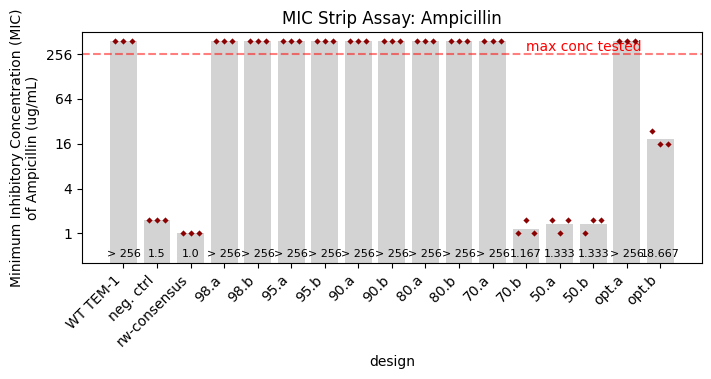

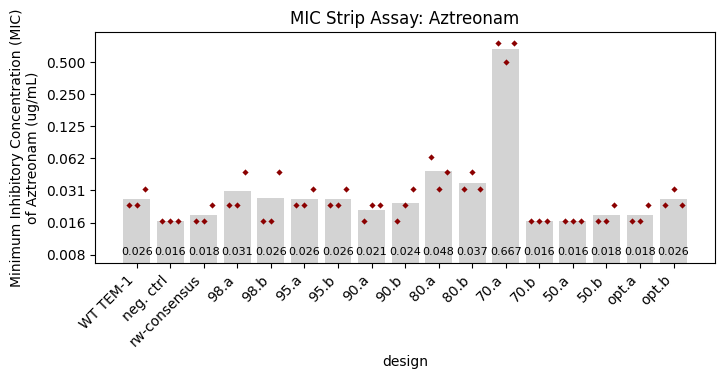

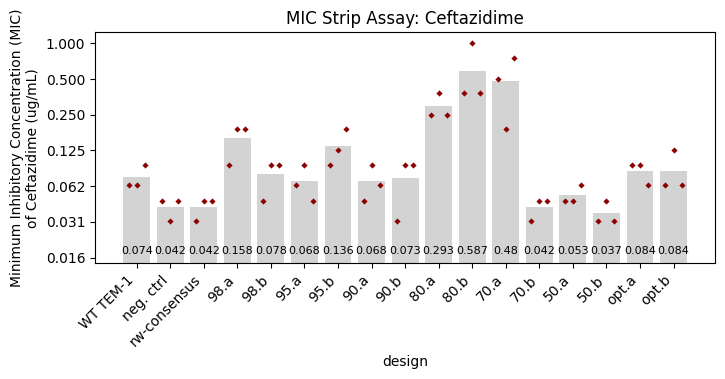

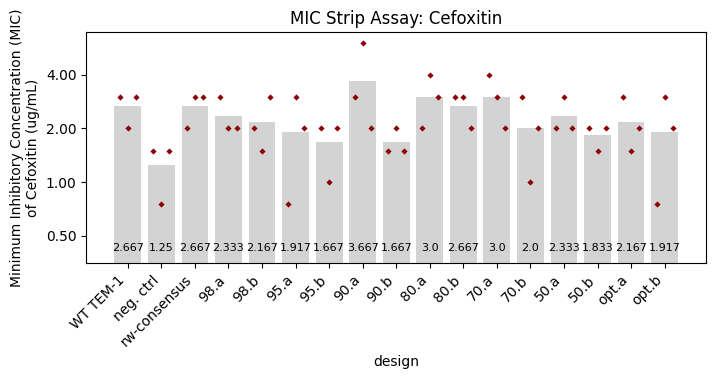

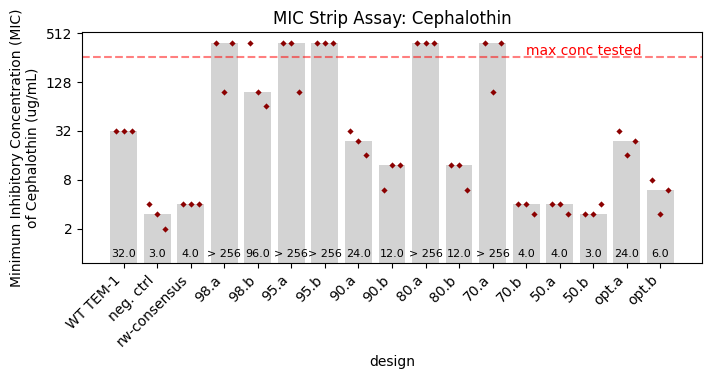

In [7]:
#Plot antibiotics that don't have weird outliers in some replicates
for antibiotic in ['Ampicillin', 'Aztreonam', 'Ceftazidime', 'Cefoxitin', 'Cephalothin']:
    plot(antibiotic=antibiotic, save_fig=False, hide_labels=False)

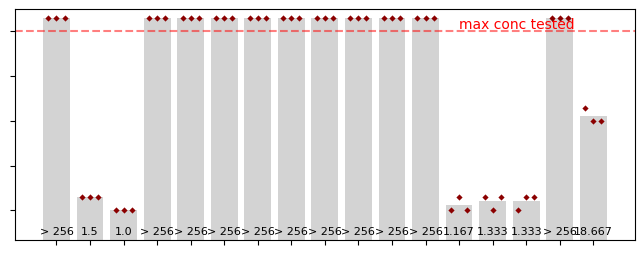

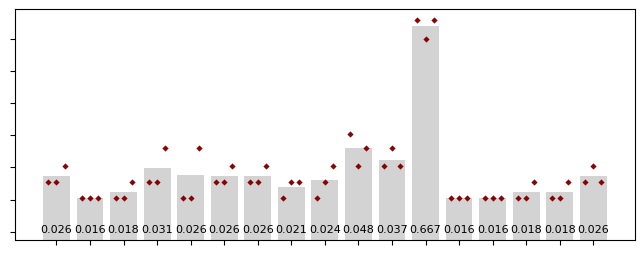

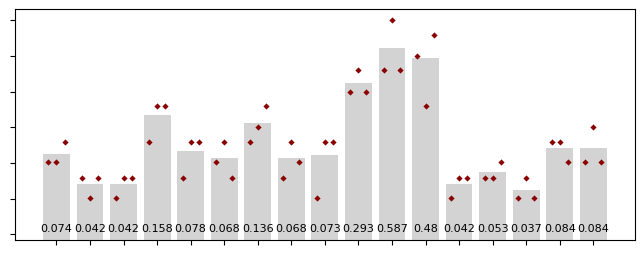

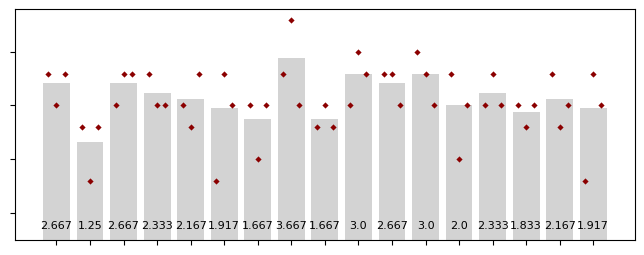

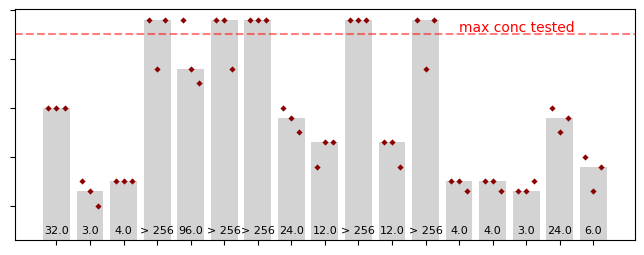

In [8]:
#output for actual PDF - to standardize exact sizing and add labels etc later
for antibiotic in ['Ampicillin', 'Aztreonam', 'Ceftazidime', 'Cefoxitin', 'Cephalothin']:
    plot(antibiotic=antibiotic, save_fig=True, hide_labels=True)

In [9]:
def output_source_data():
    for antibioitic in ['Aztreonam', 'Ceftazidime', 'Cephalothin']:
        sample_order = FHS.get_sample_order(
            df[df.antibiotic==antibioitic].manuscript_name
        )
        
        df[df.antibiotic==antibioitic].assign(
            sort_manuscript_order = lambda df: df.manuscript_name.apply(
                lambda samplename: sample_order.index(samplename)
            )
        ).sort_values(
            by=['sort_manuscript_order', 'replicate']
        )[[
            'sample_id', 'replicate', 'value', 'agg_value'
        ]].rename(columns={
            'sample_id': 'Sample',
            'replicate': 'Rep #',
            'value': 'Replicate MIC (ug/mL)',
            'agg_value': 'Sample MIC (ug/mL)',
        }).to_csv(
            OUTPUT_DIR+'/source_data_{0}.tab'.format(antibioitic), 
            sep ='\t', 
            index=False
        )
        
output_source_data()

In [10]:
#plot individual replicates as bars
def plot_individual_replicates(antibiotic, save_fig=False, hide_labels=False):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(16, 6)

    sns.barplot(
        data=df[df.antibiotic==antibiotic], 
        x='manuscript_name', y='value', 
        color='darkgray',
        palette={
            1: 'lightgray',
            2: 'darkgray',
            3: 'gray'
        },
        hue='replicate',
        order=sample_order,
        ax=ax
    )
    ax.axhline(y = MAX_TESTED, color = 'red', linestyle = '--', alpha=0.5)
    ax.text(x=12, y=MAX_TESTED, 
            s='max conc tested ({0} ug/mL)'.format(MAX_TESTED), 
            verticalalignment='bottom',
            color='red')
    
    ax.set_title('MIC Strip Assay: {0}'.format(antibiotic))
    ax.set_ylabel('Minimum Inhibitory Concentration (MIC)\nof {0} (ug/mL)'.format(antibiotic))
    ax.set_xlabel('design')
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    
    if hide_labels:
        ax.title.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.set_yticklabels([])
        ax.xaxis.label.set_visible(False)
        ax.set_xticklabels([])
    
    if save_fig: fig.savefig(OUTPUT_DIR+'/micstrip_replicates_{0}.pdf'.format(antibiotic))

#plot_individual_replicates('Ampicillin', 'Aztreonam', 'Ceftazidime', 'Cefoxitin', 'Cephalothin']:

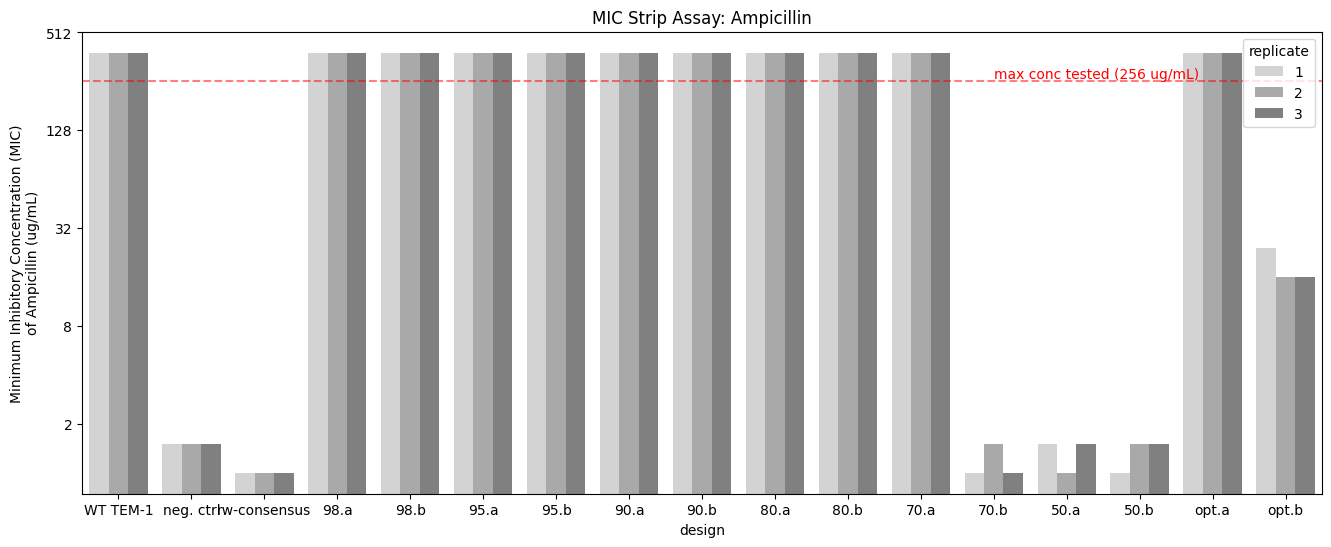

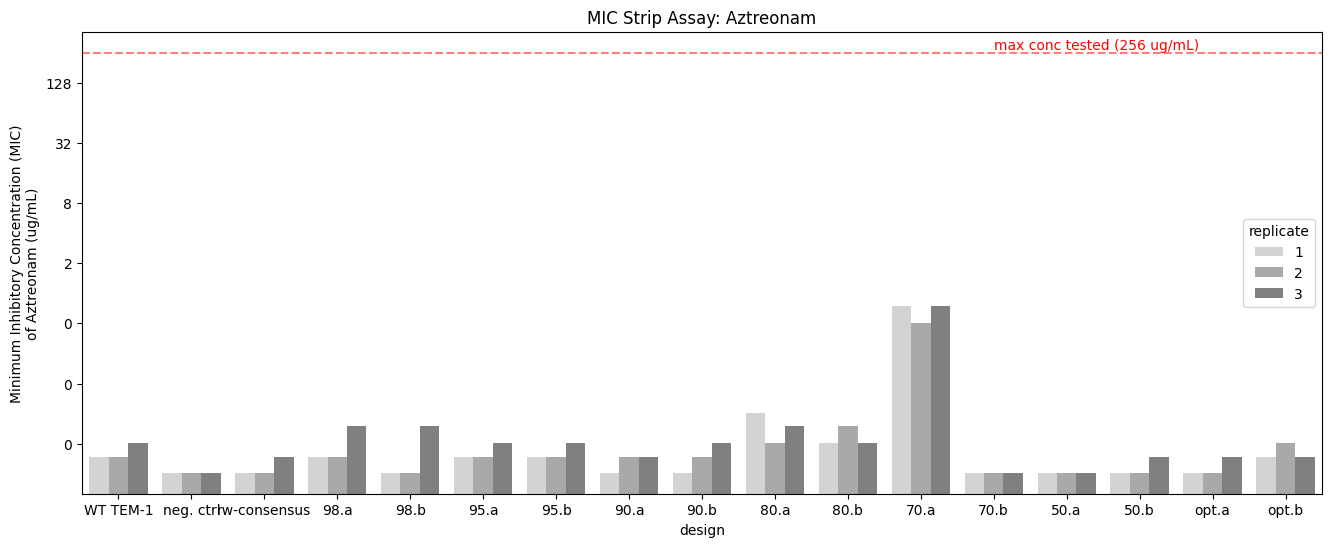

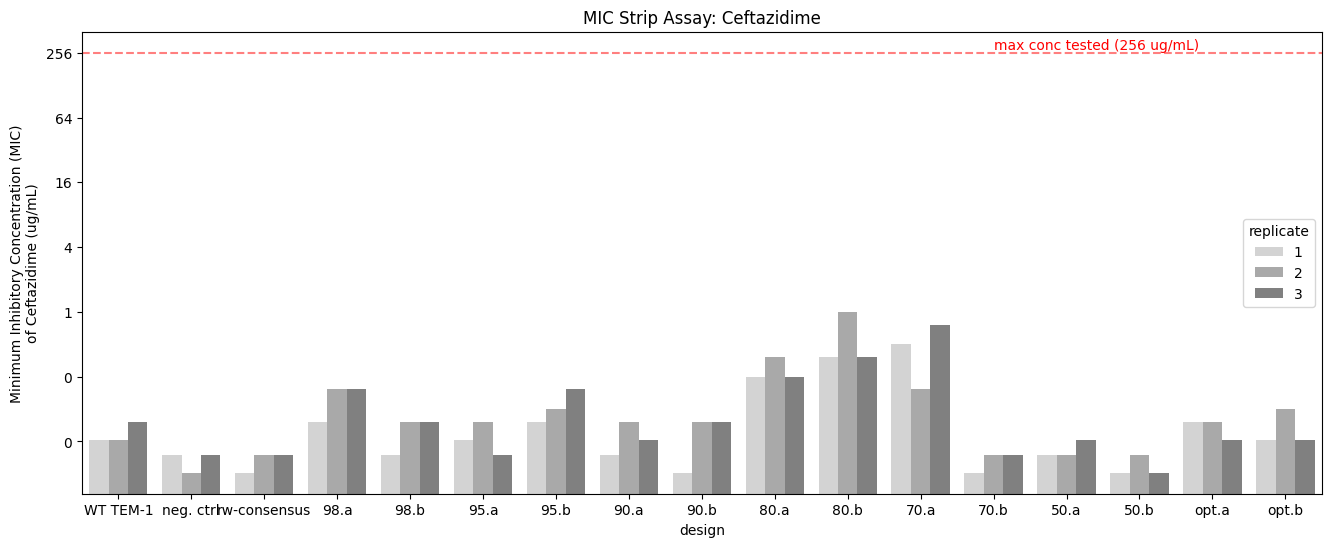

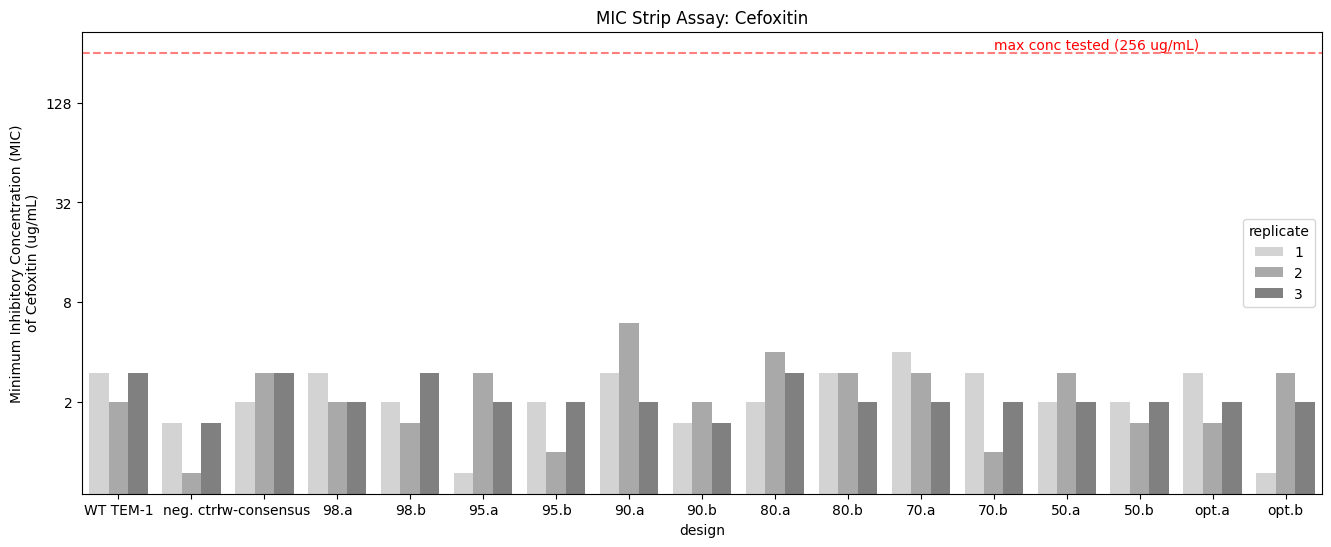

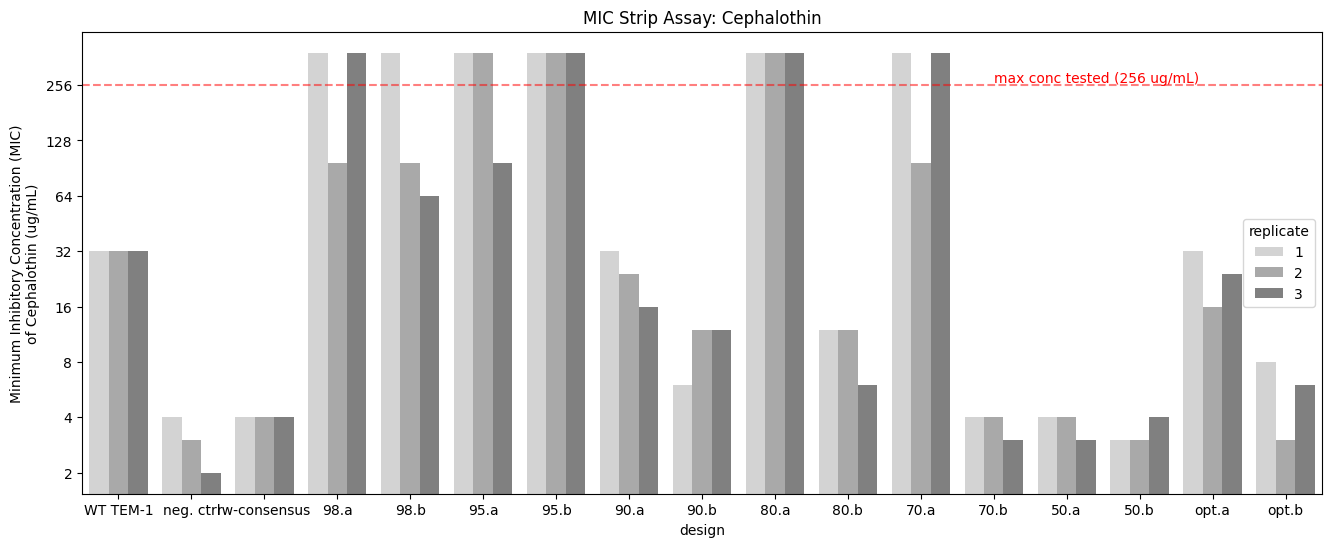

In [11]:
for antibiotic in ['Ampicillin', 'Aztreonam', 'Ceftazidime', 'Cefoxitin', 'Cephalothin']:
    plot_individual_replicates(antibiotic, save_fig=False, hide_labels=False)